#### ==========================
#### Fuel Consumption Prediction (OpenVINO-compatible)
#### ==========================

In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

##### --------------------------
##### 1. Load data
##### --------------------------

In [10]:
df = pd.read_csv("sample_trips.csv")

# Target: fuel consumption per 100km
df['fuel_l_per_100km'] = (df['fuel_liters'] / df['route_distance_km']) * 100

features = [
    'num_cars','load_weight_kg','route_distance_km','avg_speed_kmh',
    'elevation_gain_m','ambient_temp_c','rain_mm','wind_kmh'
]
target = 'fuel_l_per_100km'

X = df[features].values.astype(np.float32)
y = df[target].values.astype(np.float32).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Convert to PyTorch tensors
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_test_t = torch.from_numpy(X_test)
y_test_t = torch.from_numpy(y_test)

##### --------------------------
##### 2. Define a small MLP
##### --------------------------

In [11]:
class FuelMLP(nn.Module):
    def __init__(self, input_dim):
        super(FuelMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.layers(x)

model = FuelMLP(len(features))

##### --------------------------
##### 3. Train the model
##### --------------------------

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(200):
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()

print("Training finished!")

Training finished!


##### --------------------------
##### 4. Evaluate
##### --------------------------

In [13]:
with torch.no_grad():
    preds = model(X_test_t).numpy()

mae = np.mean(np.abs(preds - y_test))
r2 = 1 - np.sum((preds - y_test)**2)/np.sum((y_test - np.mean(y_test))**2)
print(f"MAE: {mae:.2f}, R2: {r2:.2f}")

MAE: 3.95, R2: -5.74


##### --------------------------
##### 5. Feature importance (via simple permutation)
##### --------------------------

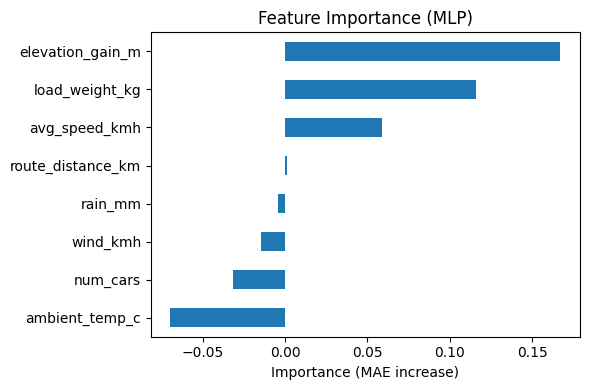

In [14]:
perm_importance = []
baseline = np.mean(np.abs(model(X_test_t).detach().numpy() - y_test))
for i in range(len(features)):
    X_perm = X_test.copy()
    np.random.shuffle(X_perm[:,i])
    perm_pred = model(torch.from_numpy(X_perm)).detach().numpy()
    perm_importance.append(np.mean(np.abs(perm_pred - y_test)) - baseline)

fi = pd.Series(perm_importance, index=features).sort_values(ascending=False)

plt.figure(figsize=(6,4))
fi.sort_values().plot(kind='barh')
plt.title("Feature Importance (MLP)")
plt.xlabel("Importance (MAE increase)")
plt.tight_layout()
plt.show()

##### --------------------------
##### 6. Export to ONNX (OpenVINO compatible)
##### --------------------------

In [15]:
dummy_input = torch.from_numpy(X_test[:1])
torch.onnx.export(
    model,
    dummy_input,
    "model/1/model.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)
print("Saved OpenVINO-compatible ONNX model to model/1/model.onnx")

Saved OpenVINO-compatible ONNX model to model/1/model.onnx


##### --------------------------
##### 7. Predict a planned trip
##### --------------------------

In [16]:
planned_trip = pd.DataFrame([{
    'num_cars': 7,
    'load_weight_kg': 7 * 1450,  # 7 cars ~1450kg each
    'route_distance_km': 680,
    'avg_speed_kmh': 78,
    'elevation_gain_m': 550,
    'ambient_temp_c': 26,
    'rain_mm': 3.0,
    'wind_kmh': 12
}])

planned_input = torch.from_numpy(planned_trip[features].values.astype(np.float32))
pred = model(planned_input).detach().numpy()[0,0]

print(f"Predicted consumption: {pred:.2f} L/100km, estimated total fuel: {pred * planned_trip['route_distance_km'][0] / 100:.1f} L")

Predicted consumption: 32.12 L/100km, estimated total fuel: 218.4 L
